In [50]:
import numpy as np 
from scipy.special import softmax 
import time 

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys 
sys.path.append("..") 
from utils.env import frozen_lake, cart_pole
from utils.viz import viz 
viz.get_style()

In [263]:
class cart_pole:

    def __init__(self, seed=1234, dt=0.02, gravity=9.8, mass_cart=1.0, mass_pole=0.1, length=0.7, force_mag=10.0, tau=0.02):
        np.random.seed(seed)
        # Physical constants
        self.dt = dt                # time step (s)
        self.gravity = gravity      # gravitational constant
        self.mass_cart = mass_cart  # mass of the cart (kg)
        self.mass_pole = mass_pole  # mass of the pole (kg)
        self.length = length        # length of the pole (m)
        self.force_mag = force_mag  # maximum magnitude of the force (N)
        self.tau = tau  # time interval for the simulation (s)

        # State variables
        self.state = np.zeros(4)  # [x, x_dot, theta, theta_dot]
        self.nS = 4
        
        # The action space is continuous: force magnitude between -1 and 1
        # We will apply the action to force the cart to move
        self.action_space = (-1.0, 1.0)
        
    def reset(self):
        # Reset the state to a random initial position and velocity
        self.state = np.random.uniform(low=-0.05, high=0.05, size=4)  # Random initial state
        return np.copy(self.state), 0, False
    
    def step(self, action):
        # Extract state variables
        x, x_dot, theta, theta_dot = self.state
        
        # Apply the continuous action (force between -1 and 1)
        force = action * self.force_mag
        
        # Physics equations of motion
        # Based on the linearized equations of the cart-pole system
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        total_mass = self.mass_cart + self.mass_pole
        pole_mass_length = self.mass_pole * self.length
        
        # Equations of motion
        temp = (force + pole_mass_length * theta_dot**2 * sin_theta) / total_mass
        theta_acc = (self.gravity * sin_theta - cos_theta * temp) / (self.length * (4/3 - self.mass_pole * cos_theta**2 / total_mass))
        x_acc = temp - pole_mass_length * theta_acc * cos_theta / total_mass
        
        # Update the state using Euler's method
        x += self.dt * x_dot
        x_dot += self.dt * x_acc
        theta += self.dt * theta_dot
        theta_dot += self.dt * theta_acc
        
        # Update the state
        self.state = np.array([x, x_dot, theta, theta_dot])
        
        # Check if the pole has fallen
        done = bool(theta < -np.pi/2 or theta > np.pi/2 or x < -2.4 or x > 2.4)
        
        # Reward: 1 for each time step the pole is balanced
        reward = 1.0
        
        return np.copy(self.state), reward, done
    
    def render(self, ax):
        # Visualization of the cart-pole system
        x, _, theta, _ = self.state
        cart_x = x
        pole_length = self.length
        pole_x = cart_x + pole_length * np.sin(theta)
        pole_y = pole_length * np.cos(theta)
                
        # Draw the cart
        cart_width = 0.3
        cart_height = 0.24
        ax.add_patch(plt.Rectangle((cart_x - cart_width/2, -cart_height/2), cart_width, cart_height, color='blue'))
        
        # Draw the horizontal line
        ax.axhline(y=0, color='k',lw=3)

        # Draw the pole
        ax.plot([cart_x, pole_x], [0, pole_y], color='red', lw=3)
        ax.plot(cart_x, 0, 'ko')  # Draw the cart axle
        ax.set_axis_off()
        ax.set_aspect('equal')
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.3, 1.3)

    def close(self):
        plt.close()

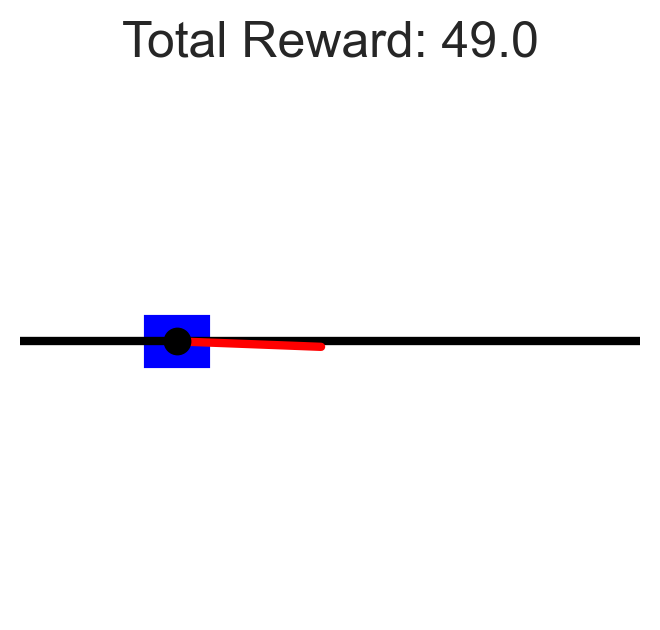

In [100]:
env = cart_pole()
s, _, done = env.reset()
total_reward = 0
while not done:
    
    # Sample a random continuous action (force between -1 and 1)
    action = np.random.uniform(-1.0, 1.0)
    next_s, r, done = env.step(action)
    total_reward += r
    
    # visualize
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    clear_output(True)
    env.render(ax)
    ax.set_title(f'Total Reward: {total_reward}')
    plt.show()
    time.sleep(0.05)

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim

In [237]:
class neural_net_policy(nn.Module):

    def __init__(self, nS, nA, alpha, gamma, hidden_dim=128):
        super().__init__()
        self.gamma = gamma
        self.l1 = nn.Linear(nS, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, nA)
        self.logsig = nn.Parameter(torch.zeros(nA))
        # optimizer 
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

    def forward(self, s):
        # state -> action (mean of Gaussian)
        x = torch.relu(self.l1(s))
        x = torch.relu(self.l2(x))
        return torch.tanh(self.l3(x)), self.logsig
    
    def get_action(self, s):
        s = torch.from_numpy(s).float().unsqueeze(0)
        mu, logsig = self.forward(s)
        dist = torch.distributions.Normal(mu, logsig.exp())
        a = dist.sample()
        log_prob = dist.log_prob(a)
        return a.numpy()[0, 0], log_prob.sum()
    
    def update(self, log_probs, rs):
        # compute returns 
        returns = []
        G = 0
        for r in reversed(rs):
            G = r + self.gamma * G
            returns.insert(0, G)
        # tensorize 
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        log_probs = torch.hstack(log_probs)
        # compute loss 
        loss = -(returns * log_probs).mean()
        # update 
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [238]:
class random_policy:

    def __init__(self, nS, nA, alpha, gamma, hidden_dim=128):
        pass

    def get_action(self, s):
        return np.random.uniform(-1.0, 1.0), 0
    
    def update(self, log_probs, rs):
        pass

In [245]:
def REINFORCE(env, policy_strategy, alpha=.1, gamma=.99, 
                  seed=1234, 
                  show_trajectory=False, 
                  show_intval=200, max_steps=300,
                  max_episodes=10000):
    
    # initialize random seed
    torch.manual_seed(seed)    
    # init a list to record the model performance per episode
    model_performance = []
    # initialize the policy strategy
    policy = policy_strategy(env.nS, 1, alpha, gamma)

    # loop over episodes 
    for epi in range(max_episodes):

        # rollout the episode 
        s, _, _ = env.reset()
        log_probs, rs = [], [] 
        step = 0
        total_reward = 0
        while True:
            a, log_prob = policy.get_action(s)
            s_next, r, done = env.step(a)
            log_probs.append(log_prob)
            rs.append(r)
            s = s_next
            step += 1
            total_reward += r
                       
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 1, figsize=(4, 4))
                clear_output(True)
                env.render(ax)
                ax.set_title(f'Epi: {epi+1}, Reward: {total_reward}')
                plt.show()
                time.sleep(0.05)

            if done or (step>max_steps): 
                model_performance.append(total_reward)
                break
        
        # update the policy 
        policy.update(log_probs, rs)

    return model_performance

In [246]:
def show_lr_curves(model_performances, window_size=40, step_unit=100, x_range=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
    for lbl, curve in model_performances.items():
        # smooth the learning curve 
        smoothed_curve = np.convolve(curve, np.ones(window_size)/window_size, mode='valid')
        t = np.arange(len(smoothed_curve))
        sns.lineplot(x=t, y=smoothed_curve, ax=ax, label=lbl)
    for pos in ['left', 'bottom']: ax.spines[pos].set_linewidth(3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    #ax.set_ylim([0, 105])
    if x_range is not None: ax.set_xlim(x_range)
    ax.set_xlabel(f'Every {step_unit} steps')
    ax.set_ylabel('Reward')
    plt.show()

In [259]:
lr_curves = {}

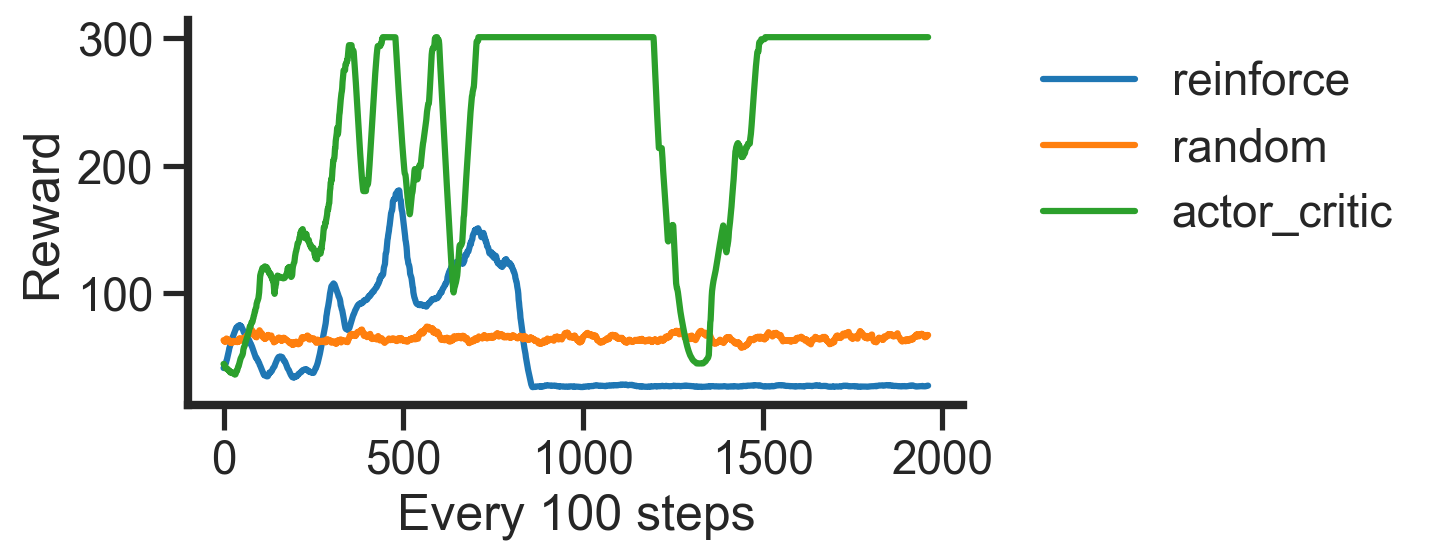

In [285]:
seed = 98
np.random.seed(seed)
env = cart_pole()
mp = REINFORCE(env, policy_strategy=neural_net_policy, 
                        alpha=5e-3,
                        seed=seed+1,
                        show_trajectory=False,
                        max_episodes=2000)
lr_curves['reinforce'] = mp
show_lr_curves(lr_curves)

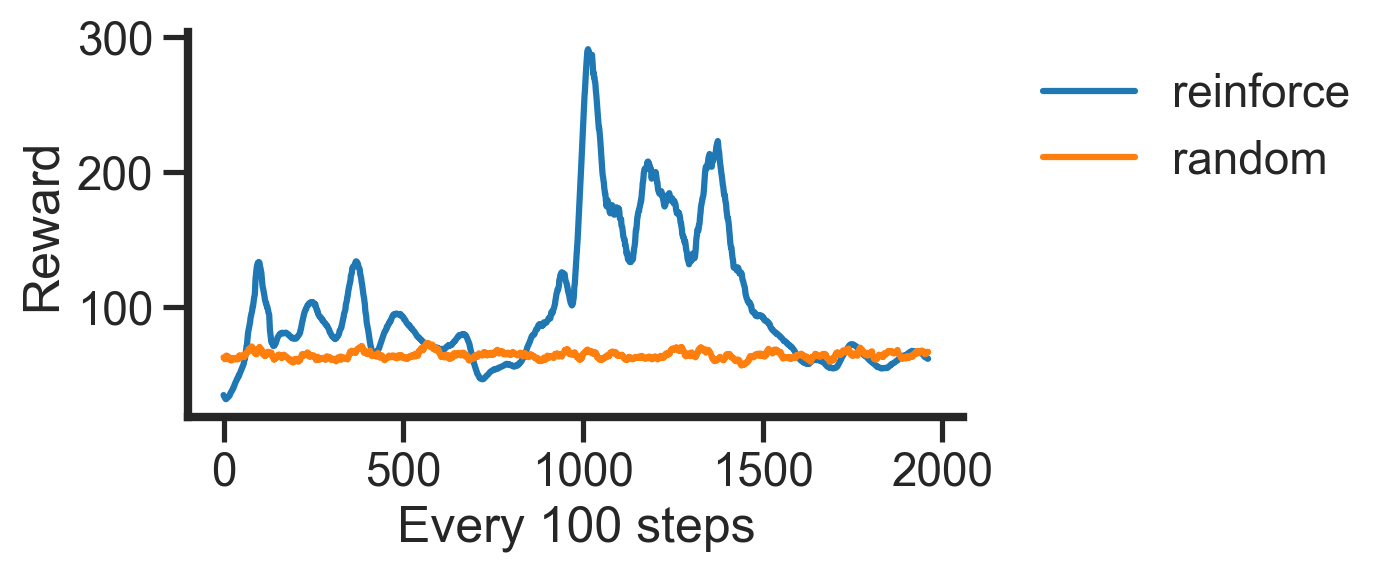

In [ ]:
seed = 98
np.random.seed(seed)
env = cart_pole()
mp = REINFORCE(env, policy_strategy=random_policy, 
                        alpha=.005,
                        seed=seed+1,
                        show_trajectory=False,
                        max_episodes=2000)
lr_curves['random'] = mp
show_lr_curves(lr_curves)

In [273]:
class Actor(nn.Module):
    def __init__(self, nS, nA, alpha, hidden_dim=128):
        super().__init__()
        self.l1 = nn.Linear(nS, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, nA)
        self.logsig = nn.Parameter(torch.zeros(nA))
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

    def forward(self, s):
        x = torch.relu(self.l1(s))
        x = torch.relu(self.l2(x))
        return torch.tanh(self.l3(x)), self.logsig

    def get_action(self, s):
        s = torch.from_numpy(s).float().unsqueeze(0)
        mu, logsig = self.forward(s)
        dist = torch.distributions.Normal(mu, logsig.exp())
        a = dist.sample()
        log_prob = dist.log_prob(a).sum()
        return a.detach().numpy()[0, 0], log_prob

class Critic(nn.Module):
    def __init__(self, nS, alpha, hidden_dim=128):
        super().__init__()
        self.l1 = nn.Linear(nS, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

    def forward(self, s):
        x = torch.relu(self.l1(s))
        x = torch.relu(self.l2(x))
        return self.l3(x).squeeze()

class actor_critic_policy:
    def __init__(self, nS, nA, alpha_actor=1e-4, alpha_critic=1e-4, gamma=0.99, hidden_dim=128):
        self.actor = Actor(nS, nA, alpha_actor, hidden_dim)
        self.critic = Critic(nS, alpha_critic, hidden_dim)
        self.gamma = gamma

    def get_action(self, s):
        action, log_prob = self.actor.get_action(s)
        return action, log_prob

    def update(self, log_prob, s, r, s_next, done):
        s = torch.from_numpy(s).float().unsqueeze(0)
        s_next = torch.from_numpy(s_next).float().unsqueeze(0)
        v = self.critic.forward(s)
        v_next = self.critic.forward(s_next)

        # Compute TD targets and advantages 
        with torch.no_grad():
            next_state_values = v_next * (1 - done)
            q = r + self.gamma * next_state_values
            advantage = q - v

        # Actor loss
        actor_loss = -(advantage * log_prob).mean()

        # Critic loss
        critic_loss = (q - v).square().mean()

        # Update actor
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()

        # Update critic
        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()


In [276]:
def actor_critic(env, policy_strategy, 
                  alpha_critic=.1, alpha_actor=.1,
                  gamma=.99, 
                  seed=1234, 
                  show_trajectory=False, 
                  show_intval=200, max_steps=300,
                  max_episodes=10000):
    
    # initialize random seed
    torch.manual_seed(seed)    
    # init a list to record the model performance per episode
    model_performance = []
    # initialize the policy strategy
    ac_agent = policy_strategy(env.nS, 1, 
                               alpha_critic=alpha_critic, 
                               alpha_actor=alpha_actor, 
                               gamma=gamma)

    # loop over episodes 
    for epi in range(max_episodes):

        # rollout the episode 
        s, _, _ = env.reset()
        step = 0
        total_reward = 0
        while True:
            a, log_prob = ac_agent.get_action(s)
            s_next, r, done = env.step(a)
            # update the policy 
            ac_agent.update(log_prob, s, r, s_next, done)

            s = s_next
            step += 1
            total_reward += r
                       
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 1, figsize=(4, 4))
                clear_output(True)
                env.render(ax)
                ax.set_title(f'Epi: {epi+1}, Reward: {total_reward}')
                plt.show()
                time.sleep(0.05)

            if done or (step>max_steps): 
                model_performance.append(total_reward)
                break
        
        
    return model_performance

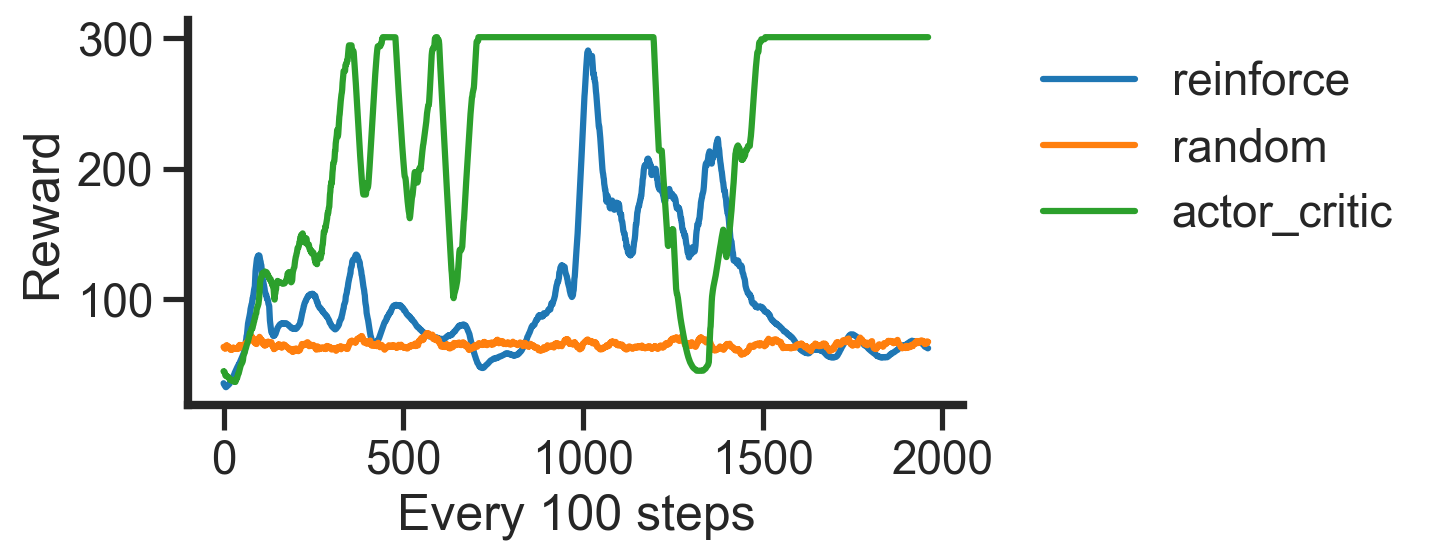

In [281]:
seed = 98
np.random.seed(seed)
env = cart_pole()
mp = actor_critic(env, policy_strategy=actor_critic_policy, 
                        alpha_critic=1e-3,
                        alpha_actor=1e-4,
                        show_trajectory=False,
                        max_episodes=2000)
lr_curves['actor_critic'] = mp
show_lr_curves(lr_curves)